# Problem statement

### Which machine learning model works best for binary classification? 
There won't be a single answer to this question, but I am curious about how different models perform on the same dataset. 

My data is the IBM Telco customer churn dataset ([https://www.kaggle.com/blastchar/telco-customer-churn/data#]). It classifies about 7000 customers into "renew" (churn = 0) or "leave" (churn = 1). One benefit of this dataset is that it is realistic because it is imbalanced: there are many more people who stay than leave. 

### Does one-hot encoding impact the results?
For binary classification, column values need to be numbers. It is also generally recommended to bin continuous values (categorize groups of numbers) and to one-hot encode columns that have more than two states (e.g. values of 0, 1, 2, and 3 instead of just 0 and 1). 

This is straightforward for a dataset with a small number of columns, but a big hassle for a dataset with a large number of columns. Do these steps actually improve the results? I'm going to run the same models on two sets of fields: one hasn't been binned and encoded, and the other has. 

### Which metrics are useful in evaluating an imbalanced binary classification dataset?
Accuracy is the default metric of many models, but accuracy is terrible on imbalanced datasets because many models accidentally classify as the larger subset, artifically inflating the accuracy. (In this case, a model that predicted everyone would stay would have high accuracy because there are many more "stay" cases in the dataset.)

Based on suggestions, I'm going to look at AUC-ROC (area under the curve), F1 score (which tries to balance performance on positive and negative values), and time. Ideally we'd have a highly accurate model that was also fast. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np                                 # handling numbers
import matplotlib.pyplot as plt                    # basic plotting
import pandas as pd                                # dataframe manipulation
import seaborn as sns                              # pretty plotting
import plotly.graph_objects as go                  # for table of text

import sklearn                         # machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler # some data has to be scaled before you run the model
from sklearn.cluster import KMeans

#evaluating models          
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score # f1_score is a balance between precision and recall
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

#creating list of possible predictions
from itertools import product
import time

# reference: https://scikit-learn.org/stable/index.html, Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
# reference: https://medium.com/analytics-vidhya/your-ultimate-data-mining-machine-learning-cheat-sheet-9fce3fa16


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# so that colab doesn't limit how much data it shows in a chunk
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [0]:
sns.set_palette('coolwarm')

## Import, clean, and prepare data

In [0]:
# downloaded data from: https://www.kaggle.com/blastchar/telco-customer-churn/data#

telco = pd.read_csv('/content/drive/My Drive/Week9_CustomerChurn/telco_churn_7000.csv')

In [5]:
telco.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [6]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# Customer ID won't be useful
# Change the format of the names of the columns to be consistent

df = telco.drop(columns=['customerID'])
df.columns = map(str.capitalize, df.columns)
df.head()

# reference: https://chrisalbon.com/python/data_wrangling/pandas_lowercase_column_names/


,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


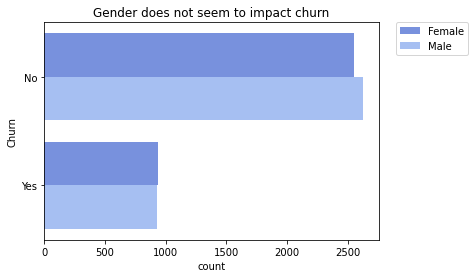

In [131]:
# Gender does not seem to be a factor in churn

sns.countplot(y= 'Churn', data=df, hue='Gender')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Gender does not seem to impact churn')
plt.show()

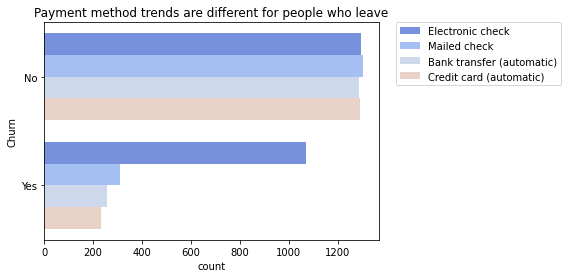

In [129]:
sns.countplot(y= 'Churn', data=df, hue='Paymentmethod')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Payment method trends are different for people who leave')
plt.show()

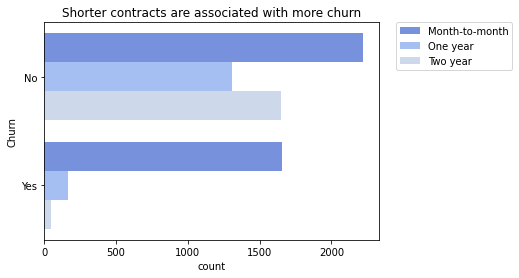

In [127]:
sns.countplot(y= 'Churn', data=df, hue='Contract')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Shorter contracts are associated with more churn')
plt.show()

In [8]:
# what are the possible values for each column? 
# there are three numeric columns that will be binned in the second set of models

for col in df:
    print(df[col].unique())

# reference: https://stackoverflow.com/questions/27241253/print-the-unique-values-in-every-column-in-a-pandas-dataframe

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
['No' 'Yes']
['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
['No' 'Yes']


### Prepare first set of fields

* For fields that had text, I replaced them with integers. When possible, I chose two states (0, 1). Fields with more than two states will be one-hot encoded in the second set of models. 

In [9]:
# turn variables into numbers because several models prefer numeric inputs
# there are faster ways of doing this, but I like that the code documents the mapping clearly

# reference: https://stackoverflow.com/questions/47141187/factorize-a-column-of-strings-in-pandas
# sample: v.replace({'yes' : 1, 'no' : 0})

df2 = df.copy()
df2['Gender'] = df2['Gender'].replace({'Female': 0, 'Male': 1})
df2['Partner'] = df2['Partner'].replace({'No': 0, 'Yes': 1})
df2['Dependents'] = df2['Dependents'].replace({'No': 0, 'Yes': 1})
df2['Phoneservice'] = df2['Phoneservice'].replace({'No': 0, 'Yes': 1})
df2['Multiplelines'] = df2['Multiplelines'].replace({'No': 0, 'Yes': 1, 'No phone service': 0})
df2['Internetservice'] = df2['Internetservice'].replace({'DSL':1, 'Fiber optic': 2, 'No':0})
df2['Onlinesecurity'] = df2['Onlinesecurity'].replace({'No': 0, 'Yes': 1, 'No internet service': 0})
df2['Onlinebackup'] = df2['Onlinebackup'].replace({'No': 0, 'Yes': 1, 'No internet service': 0})
df2['Deviceprotection'] = df2['Deviceprotection'].replace({'No': 0, 'Yes': 1, 'No internet service': 0})
df2['Techsupport'] = df2['Techsupport'].replace({'No': 0, 'Yes': 1, 'No internet service': 0})
df2['Streamingtv'] = df2['Streamingtv'].replace({'No': 0, 'Yes': 1, 'No internet service': 0})
df2['Streamingmovies'] = df2['Streamingmovies'].replace({'No': 0, 'Yes': 1, 'No internet service': 0})
df2['Contract'] = df2['Contract'].replace({'Month-to-month':0, 'One year':1, 'Two year':2})
df2['Paperlessbilling'] = df2['Paperlessbilling'].replace({'No': 0, 'Yes': 1})
df2['Paymentmethod'] = df2['Paymentmethod'].replace({'Electronic check':1, 'Mailed check':0,'Bank transfer (automatic)':3,'Credit card (automatic)':2})
df2['Churn'] = df2['Churn'].replace({'No': 0, 'Yes': 1})
df2.head()

,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,29.85,29.85,0
1,1,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,0,56.95,1889.5,0
2,1,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,1,0,1,1,0,0,1,0,3,42.30,1840.75,0
4,0,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,1,70.70,151.65,1


In [10]:
# reference: https://datatofish.com/convert-string-to-float-dataframe/
# reference: https://datatofish.com/round-values-pandas-dataframe/, df['DataFrame column'].apply(np.ceil)
# reference: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns, 
# reference: https://numpy.org/doc/1.18/reference/generated/numpy.where.html, np.where(a < 5, a, 10*a)

df2['Totalcharges'] = pd.to_numeric(df2['Totalcharges'], errors='coerce')
df2['Monthlycharges'] = pd.to_numeric(df2['Monthlycharges'], errors='coerce')
df2['Extracharges'] = abs(round(df2['Totalcharges'] - df2['Monthlycharges'],0))
df2['Extracharges'] = df2['Extracharges'].fillna(0.0)
df2['Monthlycharges'] = df2['Monthlycharges'].apply(np.ceil)

df2.head()

,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn,Extracharges
0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,30.0,29.85,0,0.0
1,1,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,0,57.0,1889.50,0,1833.0
2,1,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,0,54.0,108.15,1,54.0
3,1,0,0,0,45,0,0,1,1,0,1,1,0,0,1,0,3,43.0,1840.75,0,1798.0
4,0,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,1,71.0,151.65,1,81.0


In [11]:
df3 = df2[['Gender', 'Seniorcitizen', 'Partner', 'Dependents', 'Tenure', 'Phoneservice', 'Multiplelines',
           'Internetservice', 'Onlinesecurity', 'Deviceprotection', 'Techsupport', 'Streamingtv', 
           'Streamingmovies', 'Contract', 'Paperlessbilling', 'Paymentmethod', 'Monthlycharges', 'Extracharges', 'Churn']]
          
df3.head()

,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Extracharges,Churn
0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,30.0,0.0,0
1,1,0,0,0,34,1,0,1,1,1,0,0,0,1,0,0,57.0,1833.0,0
2,1,0,0,0,2,1,0,1,1,0,0,0,0,0,1,0,54.0,54.0,1
3,1,0,0,0,45,0,0,1,1,1,1,0,0,1,0,3,43.0,1798.0,0
4,0,0,0,0,2,1,0,2,0,0,0,0,0,0,1,1,71.0,81.0,1


In [0]:
# box plots or other graphs

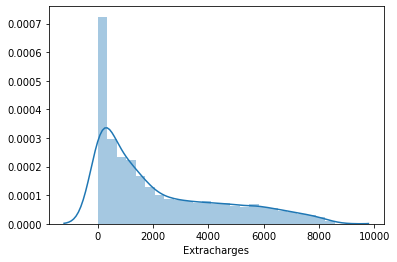

In [13]:
sns.distplot(df2['Extracharges']) 

In [14]:
# this is a like a describe function, but it is showing the things I care about most
# look for blanks and types
model_nans = df3.isnull().sum()

# check the types of the columns to see if there is text anywhere we aren't expecting
model_types = df3.dtypes

# calculate mean and median
model_means = df3.mean(axis=0)
model_medians = df3.median(axis=0)

# combine them into a table
check_columns = pd.concat([model_nans, model_types, round(model_means,2), round(model_medians, 0)], axis=1)
check_columns.columns = ('NumBlanks', 'Type', 'Average', 'Median')
check_columns

,NumBlanks,Type,Average,Median
Gender,0,int64,0.50,1.0
Seniorcitizen,0,int64,0.16,0.0
Partner,0,int64,0.48,0.0
Dependents,0,int64,0.30,0.0
Tenure,0,int64,32.37,29.0
Phoneservice,0,int64,0.90,1.0
Multiplelines,0,int64,0.42,0.0
Internetservice,0,int64,1.22,1.0
Onlinesecurity,0,int64,0.29,0.0
Deviceprotection,0,int64,0.34,0.0


### Feature selection

* I looked at a correlation plot to see if there was enough variation in the fields for them to contribute to the model, and all fields look useful other than gender. 

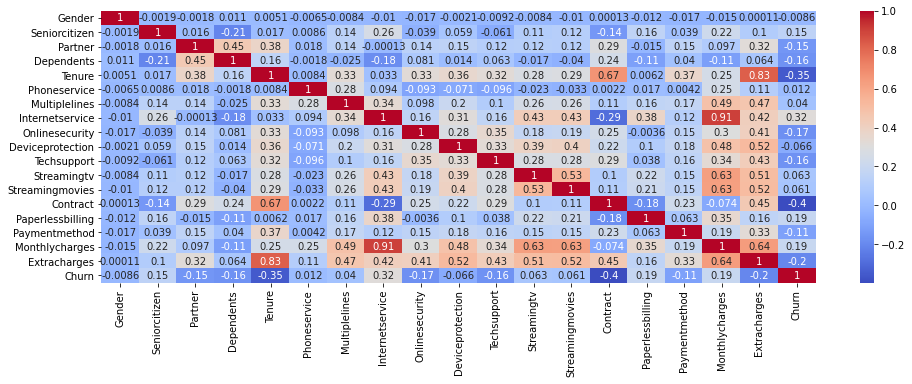

In [125]:
#sns.set_palette("coolwarm")
model_corr = df3.corr()
plt.figure(figsize=(16,5))
sns.heatmap(model_corr, cmap='coolwarm', annot=True) 

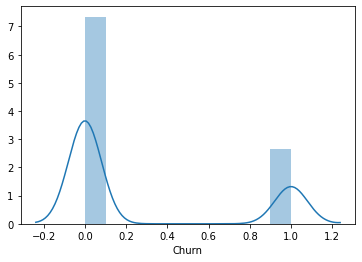

In [16]:
sns.distplot(df3['Churn']) 

### Prepare second set of fields

In [17]:
# based on the correlation plot, we can see that Gender has no impact or variation
df4 = df3.drop(columns=['Gender'])
df4.head()

,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Extracharges,Churn
0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,30.0,0.0,0
1,0,0,0,34,1,0,1,1,1,0,0,0,1,0,0,57.0,1833.0,0
2,0,0,0,2,1,0,1,1,0,0,0,0,0,1,0,54.0,54.0,1
3,0,0,0,45,0,0,1,1,1,1,0,0,1,0,3,43.0,1798.0,0
4,0,0,0,2,1,0,2,0,0,0,0,0,0,1,1,71.0,81.0,1


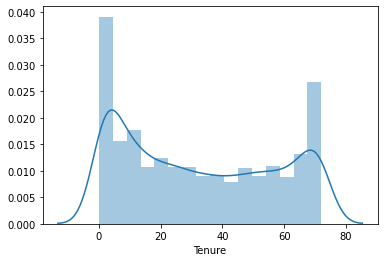

In [18]:
# before deciding how to bin Tenure, look at the distribution
sns.distplot(df4['Tenure'])

In [19]:
# Turn tenure into three bins: 0-15, 16-60, 61-80
# reference: https://pbpython.com/pandas-qcut-cut.html
# sample: pd.qcut(df['ext price'], q=4)

df4['Tenure'] = pd.cut(df4['Tenure'], bins=[0,15,60, 80], labels=[0,1,2])
df4.head()

,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Extracharges,Churn
0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,30.0,0.0,0
1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,57.0,1833.0,0
2,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,54.0,54.0,1
3,0,0,0,1,0,0,1,1,1,1,0,0,1,0,3,43.0,1798.0,0
4,0,0,0,0,1,0,2,0,0,0,0,0,0,1,1,71.0,81.0,1


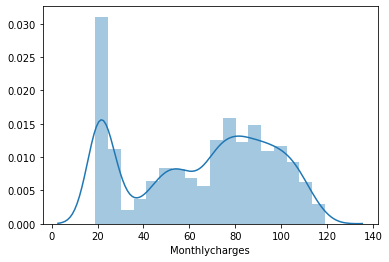

In [20]:
sns.distplot(df4['Monthlycharges'])

In [21]:

df4['Monthlycharges'] = pd.cut(df4['Monthlycharges'], bins=[0,30,70,120], labels=[0,1,2])
df4.head()

,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Extracharges,Churn
0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.0,0
1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,1,1833.0,0
2,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,54.0,1
3,0,0,0,1,0,0,1,1,1,1,0,0,1,0,3,1,1798.0,0
4,0,0,0,0,1,0,2,0,0,0,0,0,0,1,1,2,81.0,1


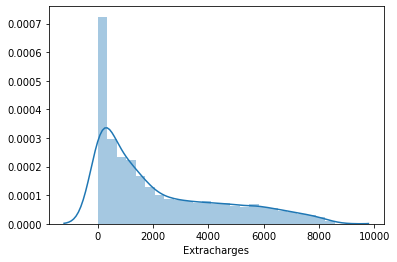

In [22]:
sns.distplot(df4['Extracharges'])

In [23]:
df4['Extracharges'] = pd.qcut(df4['Extracharges'], q=3, labels=[0,1,2])
df4.head()

,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Extracharges,Churn
0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,1,1,0
2,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1
3,0,0,0,1,0,0,1,1,1,1,0,0,1,0,3,1,1,0
4,0,0,0,0,1,0,2,0,0,0,0,0,0,1,1,2,0,1


In [0]:
tenure_df = pd.get_dummies(df4['Tenure'], prefix='Tenure')
#print(tenure_df.head())

In [0]:
monthly_df = pd.get_dummies(df4['Monthlycharges'], prefix='Monthlycharges')
#print(monthly_df.head())

In [0]:
extra_df = pd.get_dummies(df4['Extracharges'], prefix='Extracharges')
#print(extra_df.head())

In [0]:
internet_df = pd.get_dummies(df4['Internetservice'], prefix='Internetservice')
#print(internet_df.head())

In [0]:
contract_df = pd.get_dummies(df4['Contract'], prefix='Contract')
#print(contract_df.head())

In [0]:
payment_df = pd.get_dummies(df4['Paymentmethod'], prefix='Paymentmethod')
#print(payment_df.head())

In [30]:
df4.head()

,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Extracharges,Churn
0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,1,1,0
2,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1
3,0,0,0,1,0,0,1,1,1,1,0,0,1,0,3,1,1,0
4,0,0,0,0,1,0,2,0,0,0,0,0,0,1,1,2,0,1


In [31]:
# add new one-hot columns to dataframe
df5 = pd.concat([df4, tenure_df, monthly_df, extra_df, internet_df, contract_df, payment_df], axis=1)
df5.head()

,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Extracharges,Churn,Tenure_0,Tenure_1,Tenure_2,Monthlycharges_0,Monthlycharges_1,Monthlycharges_2,Extracharges_0,Extracharges_1,Extracharges_2,Internetservice_0,Internetservice_1,Internetservice_2,Contract_0,Contract_1,Contract_2,Paymentmethod_0,Paymentmethod_1,Paymentmethod_2,Paymentmethod_3
0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
2,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0
3,0,0,0,1,0,0,1,1,1,1,0,0,1,0,3,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4,0,0,0,0,1,0,2,0,0,0,0,0,0,1,1,2,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0


In [32]:
# remove the columns we are replacing with the one-hot columns
df5 = df5.drop(columns=['Tenure', 'Monthlycharges', 'Extracharges', 'Internetservice', 'Contract', 'Paymentmethod'])
df5.head()

,Seniorcitizen,Partner,Dependents,Phoneservice,Multiplelines,Onlinesecurity,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Paperlessbilling,Churn,Tenure_0,Tenure_1,Tenure_2,Monthlycharges_0,Monthlycharges_1,Monthlycharges_2,Extracharges_0,Extracharges_1,Extracharges_2,Internetservice_0,Internetservice_1,Internetservice_2,Contract_0,Contract_1,Contract_2,Paymentmethod_0,Paymentmethod_1,Paymentmethod_2,Paymentmethod_3
0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
2,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0
3,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0


## Functions for models

I've made functions for eight models, plus functions to tune each of these. I haven't comprehensively tried all tuning parameters, due to time constraints. However, I did try 9 variations of one tuning parameter for each model on each dataset. 

The time metric is calculated on the prediction step, not the tuning as a whole. 

In [35]:
# https://plotly.com/python/table/


fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Tuning Parameter']),
                 cells=dict(values=[['Logistic regression', 'K nearest neighbors', 'Random forest', 'MLP',
                                     'Naive Bayes (Gaussian)', 'Naive Bayes (Bernoulli)', 'Decision trees',
                                     'Support vector machines classifier'],
                                    ['max_iter', 'k', 'n_estimators', 'max_iter', 'var_smoothing', 'alpha',
                                     'max_depth', 'max_iter']]))
                     ])
fig.show()

In [0]:
# check that the distribution between training and test is fair across the two outcomes
# reference: code sample provided in class

def check_distribution (X_train, X_test, y_train, y_test):
  n_classes = 2

  training_counts = [None] * n_classes 
  testing_counts = [None] * n_classes
  for i in range(n_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)

  # the histogram of the data
  train_bar = plt.bar(np.arange(n_classes)-0.2, training_counts, align='center', color = 'g', alpha=0.75, width = 0.41, label='Training')
  test_bar = plt.bar(np.arange(n_classes)+0.2, testing_counts, align='center', color = 'b', alpha=0.75, width = 0.41, label = 'Testing')

  plt.xlabel('Labels')
  plt.xticks((0,1))
  plt.ylabel('Count (%)')
  plt.title('Label distribution in the training and test set')
  plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar], loc=2)
  plt.grid(True)
  plt.show()



In [0]:
# reference: https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
# import time
# start_time = time.time()
# main()
# print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
def run_logress (name, X_train, X_test, y_train, y_test, iterations):


  # reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
  start_time = time.time()
  clf = LogisticRegression(max_iter=iterations)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  dec_fn = clf.decision_function(X_test)
  #accuracy = clf.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, dec_fn)
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]

  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN


In [0]:
def run_knear (name, X_train, X_test, y_train, y_test, k):

  # reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  start_time = time.time()
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train, y_train)
  y_pred = neigh.predict(X_test)
  y_proba = neigh.predict_proba(X_test)[:,1]
  #accuracy = neigh.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]
  
  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN

In [0]:
def run_forest (name, X_train, X_test, y_train, y_test, n):

  # reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  start_time = time.time()
  forest = RandomForestClassifier(random_state=49, n_estimators = n)
  forest.fit(X_train, y_train)
  y_pred = forest.predict(X_test)
  y_proba = forest.predict_proba(X_test)[:,1]
  #accuracy = forest.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  #importances = forest.feature_importances_
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]
  
  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN


In [0]:
def run_mlp (name, X_train, X_test, y_train, y_test, iterations):

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  start_time = time.time()
  clf = MLPClassifier(random_state=49, max_iter=iterations).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_proba = clf.predict_proba(X_test)[:,1]
  #accuracy = clf.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]
  
  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN

In [0]:
def run_naive (name, X_train, X_test, y_train, y_test, smooth):

  #reference: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
  start_time = time.time()
  bay = sklearn.naive_bayes.GaussianNB(var_smoothing= smooth)
  bay.fit(X_train, y_train)
  y_pred = bay.predict(X_test)
  y_proba = bay.predict_proba(X_test)[:,1]
  #accuracy = bay.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]

  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN

In [0]:
def run_bern (name, X_train, X_test, y_train, y_test, step):

  #reference: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html?highlight=bern#sklearn.naive_bayes.BernoulliNB
  start_time = time.time()
  bay = sklearn.naive_bayes.BernoulliNB(alpha=step)
  bay.fit(X_train, y_train)
  y_pred = bay.predict(X_test)
  y_proba = bay.predict_proba(X_test)[:,1]
  #accuracy = bay.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]

  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN

In [0]:
def run_tree (name, X_train, X_test, y_train, y_test, depth):

  # reference: https://scikit-learn.org/stable/modules/tree.html#tree-classification
  start_time = time.time()
  tree = sklearn.tree.DecisionTreeClassifier(random_state=49, max_depth=depth)
  tree.fit(X_train, y_train)
  y_pred = tree.predict(X_test)
  y_proba = tree.predict_proba(X_test)[:,1]
  #accuracy = tree.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, y_proba)
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]
  
  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN



In [0]:
def run_svc (name, X_train, X_test, y_train, y_test, maxiter):

  #reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
  start_time = time.time()
  vector = make_pipeline(StandardScaler(),
                         LinearSVC(random_state=49, multi_class='ovr', max_iter=maxiter))
  vector.fit(X_train, y_train)
  y_pred = vector.predict(X_test)
  dec_fn = vector.decision_function(X_test)
  #accuracy = vector.score(X_test, y_test)
  #precision = precision_score(y_test, y_pred)
  #recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  rocauc = roc_auc_score(y_test, dec_fn )
  conf_mat = confusion_matrix(y_test, y_pred)
  time_elapsed = time.time() - start_time
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]

  return name, round(time_elapsed,3), round(f1,3), round(rocauc,3), TP, FP, FN, TN


### Tune models

In [0]:
def tune_naiveg (passname, X_train, X_test, y_train, y_test):

  # reference: https://stackoverflow.com/questions/51194627/python-naive-bayes-with-cross-validation-using-gaussiannb-classifier

  steps = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

  results = []
  for step in steps:
    name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN = run_naive (passname, X_train, X_test, y_train, y_test, step)
    evaluators = [name_x, time_x, f1_x, rocauc_x,  TP, FP, FN, TN]
    results.append(evaluators)

  results_gnb = pd.DataFrame(results)
  results_gnb = results_gnb.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})

  return results_gnb

In [0]:
def tune_bern (passname, X_train, X_test, y_train, y_test):

  steps = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

  results = []
  for step in steps:
   name_x, time_x, f1_x, rocauc_x,  TP, FP, FN, TN = run_bern (passname, X_train, X_test, y_train, y_test, step)
   evaluators = [name_x, time_x, f1_x, rocauc_x,  TP, FP, FN, TN]
   results.append(evaluators)

  results_bnb = pd.DataFrame(results)
  results_bnb = results_bnb.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})

  return results_bnb

In [0]:
def tune_tree (passname, X_train, X_test, y_train, y_test):

  steps = [3, 4, 5, 6, 7, 8, 9, 10, 11]

  results = []
  for step in steps:
    name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN = run_tree (passname, X_train, X_test, y_train, y_test, step)
    evaluators = [name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN]
    results.append(evaluators)

  results_tree = pd.DataFrame(results)
  results_tree = results_tree.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})
  
  return results_tree

In [0]:
def tune_forest (passname, X_train, X_test, y_train, y_test):

  steps = [10, 25, 50, 75, 100, 125, 150, 175, 200]

  results = []
  for step in steps:
    name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN = run_forest (passname, X_train, X_test, y_train, y_test, step)
    evaluators = [name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN]
    results.append(evaluators)

  results_rf = pd.DataFrame(results)
  results_rf = results_rf.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})

  return results_rf

In [0]:
def tune_log (passname, X_train, X_test, y_train, y_test):

  steps = [25, 50, 60, 70, 80, 90, 100, 125, 150]

  results = []
  for step in steps:
   name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN = run_logress (passname, X_train, X_test, y_train, y_test, step)
   evaluators = [name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN]
   results.append(evaluators)

  results_log = pd.DataFrame(results)
  results_log = results_log.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})

  return results_log

In [0]:
def tune_knn (passname, X_train, X_test, y_train, y_test):

  steps = [2, 4, 6, 8, 10, 12, 14, 16, 18]

  results = []
  for step in steps:
    name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN = run_knear (passname, X_train, X_test, y_train, y_test, step)
    evaluators = [name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN]
    results.append(evaluators)

  results_knn = pd.DataFrame(results)
  results_knn = results_knn.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})

  return results_knn

In [0]:
def tune_svc(passname, X_train, X_test, y_train, y_test):

  steps = [100, 500, 1000, 2500, 5000, 7500, 10000, 20000, 50000]

  results = []
  for step in steps:
    name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN = run_svc(passname, X_train, X_test, y_train, y_test, step)
    evaluators = [name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN]
    results.append(evaluators)

  results_svc = pd.DataFrame(results)
  results_svc = results_svc.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})

  return results_svc

In [0]:
def tune_mlp(passname, X_train, X_test, y_train, y_test):

  steps = [25, 50, 60, 70, 80, 90, 100, 125, 150]

  results = []
  for step in steps:
    name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN = run_mlp (passname, X_train, X_test, y_train, y_test, step)
    evaluators = [name_x, time_x, f1_x, rocauc_x, TP, FP, FN, TN]
    results.append(evaluators)

  results_mlp = pd.DataFrame(results)
  results_mlp = results_mlp.rename(columns= {0: 'Name', 1: 'Time', 2: 'F1', 3: 'AucRoc', 4: 'TP', 5:'FP', 6:'FN', 7:'TN'})

  return results_mlp

## Run first set of models

The first set of models uses the dataset without binning or one-hot encoding. 

In [0]:
# create training and test sets with 33/66 split

X1 = np.asarray(df3.drop(columns='Churn'))
y = np.asarray(df3['Churn'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.33, random_state=49)


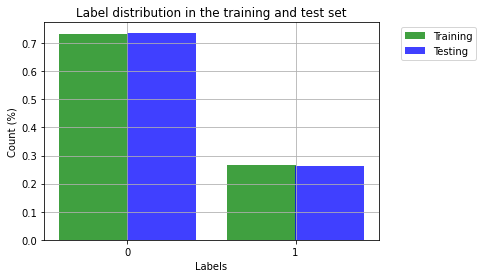

In [138]:
check_distribution(X1_train, X1_test, y1_train, y1_test)

In [56]:
confusion_matrix(y1_test, y1_test)

array([[1714,    0],
       [   0,  611]])

### Naive Bayes (Gaussian)

In [57]:
set1_naiveg = tune_naiveg ('Round 1: Naive Bayes Gaussian', X1_train, X1_test, y1_train, y1_test)
set1_naiveg

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: Naive Bayes Gaussian,0.016,0.619,0.828,1325,389,163,448
1,Round 1: Naive Bayes Gaussian,0.010,0.617,0.828,1321,393,163,448
2,Round 1: Naive Bayes Gaussian,0.010,0.606,0.813,1307,407,168,443
3,Round 1: Naive Bayes Gaussian,0.010,0.571,0.779,1386,328,236,375
4,Round 1: Naive Bayes Gaussian,0.009,0.545,0.768,1427,287,275,336
5,Round 1: Naive Bayes Gaussian,0.009,0.495,0.759,1580,134,366,245
6,Round 1: Naive Bayes Gaussian,0.008,0.000,0.716,1714,0,611,0
7,Round 1: Naive Bayes Gaussian,0.008,0.000,0.675,1714,0,611,0
8,Round 1: Naive Bayes Gaussian,0.009,0.000,0.659,1714,0,611,0


### Naive Bayes (Bernoulli)

In [58]:
set1_naiveb = tune_bern('Round 1: Naive Bayes Bernoulli', X1_train, X1_test, y1_train, y1_test)
set1_naiveb

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: Naive Bayes Bernoulli,0.024,0.607,0.827,1416,298,215,396
1,Round 1: Naive Bayes Bernoulli,0.016,0.607,0.827,1416,298,215,396
2,Round 1: Naive Bayes Bernoulli,0.010,0.607,0.827,1416,298,215,396
3,Round 1: Naive Bayes Bernoulli,0.010,0.607,0.827,1416,298,215,396
4,Round 1: Naive Bayes Bernoulli,0.010,0.607,0.827,1416,298,215,396
5,Round 1: Naive Bayes Bernoulli,0.012,0.607,0.827,1416,298,215,396
6,Round 1: Naive Bayes Bernoulli,0.013,0.607,0.827,1416,298,215,396
7,Round 1: Naive Bayes Bernoulli,0.013,0.607,0.827,1416,298,215,396
8,Round 1: Naive Bayes Bernoulli,0.011,0.607,0.827,1416,298,215,396


### Decision trees

In [59]:
set1_tree = tune_tree('Round 1: Decison tree', X1_train, X1_test, y1_train, y1_test )
set1_tree

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: Decison tree,0.018,0.467,0.819,1612,102,394,217
1,Round 1: Decison tree,0.014,0.524,0.832,1558,156,339,272
2,Round 1: Decison tree,0.015,0.560,0.828,1499,215,290,321
3,Round 1: Decison tree,0.020,0.545,0.821,1517,197,308,303
4,Round 1: Decison tree,0.019,0.566,0.814,1505,209,287,324
5,Round 1: Decison tree,0.019,0.558,0.787,1478,236,283,328
6,Round 1: Decison tree,0.021,0.565,0.775,1465,249,272,339
7,Round 1: Decison tree,0.025,0.539,0.761,1490,224,303,308
8,Round 1: Decison tree,0.023,0.524,0.734,1452,262,301,310


### Random forest

In [60]:
set1_rf = tune_forest('Round 1: Random forest', X1_train, X1_test, y1_train, y1_test )
set1_rf

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: Random forest,0.079,0.498,0.796,1534,180,349,262
1,Round 1: Random forest,0.172,0.536,0.809,1517,197,315,296
2,Round 1: Random forest,0.319,0.547,0.818,1538,176,315,296
3,Round 1: Random forest,0.465,0.549,0.820,1538,176,313,298
4,Round 1: Random forest,0.612,0.549,0.819,1545,169,316,295
5,Round 1: Random forest,0.766,0.554,0.820,1537,177,309,302
6,Round 1: Random forest,0.914,0.553,0.820,1538,176,310,301
7,Round 1: Random forest,1.083,0.557,0.820,1534,180,306,305
8,Round 1: Random forest,1.210,0.556,0.820,1540,174,309,302


### Logistic regression

In [61]:
set1_log = tune_log('Round 1: Logistic regression', X1_train, X1_test, y1_train, y1_test )
set1_log

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: Logistic regression,0.052,0.558,0.800,1485,229,286,325
1,Round 1: Logistic regression,0.073,0.573,0.836,1523,191,289,322
2,Round 1: Logistic regression,0.110,0.610,0.843,1530,184,262,349
3,Round 1: Logistic regression,0.100,0.608,0.845,1537,177,267,344
4,Round 1: Logistic regression,0.112,0.601,0.846,1536,178,272,339
5,Round 1: Logistic regression,0.129,0.602,0.844,1537,177,272,339
6,Round 1: Logistic regression,0.128,0.601,0.845,1542,172,275,336
7,Round 1: Logistic regression,0.138,0.601,0.845,1542,172,275,336
8,Round 1: Logistic regression,0.129,0.601,0.845,1542,172,275,336


### K nearest neighbors

In [62]:
set1_knn = tune_knn('Round 1: K-nearest neighbors', X1_train, X1_test, y1_train, y1_test )
set1_knn

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: K-nearest neighbors,0.134,0.369,0.686,1601,113,447,164
1,Round 1: K-nearest neighbors,0.112,0.410,0.729,1584,130,420,191
2,Round 1: K-nearest neighbors,0.104,0.422,0.751,1588,126,414,197
3,Round 1: K-nearest neighbors,0.119,0.439,0.757,1592,122,405,206
4,Round 1: K-nearest neighbors,0.107,0.425,0.766,1596,118,414,197
5,Round 1: K-nearest neighbors,0.108,0.432,0.770,1603,111,412,199
6,Round 1: K-nearest neighbors,0.110,0.431,0.772,1600,114,412,199
7,Round 1: K-nearest neighbors,0.113,0.437,0.774,1610,104,411,200
8,Round 1: K-nearest neighbors,0.114,0.448,0.776,1607,107,404,207


### Support Vector Machines

In [63]:
set1_svc = tune_svc('Round 1: Support vector', X1_train, X1_test, y1_train, y1_test )
set1_svc

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: Support vector,0.067,0.573,0.835,1545,169,298,313
1,Round 1: Support vector,0.248,0.584,0.840,1544,170,289,322
2,Round 1: Support vector,0.320,0.584,0.840,1544,170,289,322
3,Round 1: Support vector,0.314,0.584,0.840,1544,170,289,322
4,Round 1: Support vector,0.320,0.584,0.840,1544,170,289,322
5,Round 1: Support vector,0.321,0.584,0.840,1544,170,289,322
6,Round 1: Support vector,0.322,0.584,0.840,1544,170,289,322
7,Round 1: Support vector,0.326,0.584,0.840,1544,170,289,322
8,Round 1: Support vector,0.322,0.584,0.840,1544,170,289,322


### MLP

In [64]:
set1_mlp = tune_mlp('Round 1: Multilayer perceptron', X1_train, X1_test, y1_train, y1_test )
set1_mlp

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.



,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 1: Multilayer perceptron,0.671,0.534,0.768,1575,139,338,273
1,Round 1: Multilayer perceptron,0.704,0.589,0.829,1546,168,286,325
2,Round 1: Multilayer perceptron,0.702,0.589,0.829,1546,168,286,325
3,Round 1: Multilayer perceptron,0.688,0.589,0.829,1546,168,286,325
4,Round 1: Multilayer perceptron,0.693,0.589,0.829,1546,168,286,325
5,Round 1: Multilayer perceptron,0.757,0.589,0.829,1546,168,286,325
6,Round 1: Multilayer perceptron,0.692,0.589,0.829,1546,168,286,325
7,Round 1: Multilayer perceptron,0.674,0.589,0.829,1546,168,286,325
8,Round 1: Multilayer perceptron,0.689,0.589,0.829,1546,168,286,325


### Best of each model for round 1

In [113]:
round1_frames = [set1_naiveg.iloc[1,:], set1_naiveb.iloc[6,:], set1_tree.iloc[2,:], 
                 set1_tree.iloc[6,:], set1_rf.iloc[7, :], set1_log.iloc[2,:], 
                 set1_knn.iloc[8,:], set1_svc.iloc[1,:], set1_mlp.iloc[1,:]]

round1_best = pd.concat(round1_frames, axis=1)
round1_best.columns = round1_best.iloc[0]
round1_best = round1_best.transpose()
round1_best = round1_best.drop(columns=['Name'])

round1_best = round1_best.sort_values('AucRoc', ascending=False)
round1_best.sort_values(by='Time')

,Time,F1,AucRoc,TP,FP,FN,TN
Name,,,,,,,
Round 1: Naive Bayes Gaussian,0.01,0.617,0.828,1321,393,163,448
Round 1: Naive Bayes Bernoulli,0.013,0.607,0.827,1416,298,215,396
Round 1: Decison tree,0.015,0.56,0.828,1499,215,290,321
Round 1: Decison tree,0.021,0.565,0.775,1465,249,272,339
Round 1: Logistic regression,0.11,0.61,0.843,1530,184,262,349
Round 1: K-nearest neighbors,0.114,0.448,0.776,1607,107,404,207
Round 1: Support vector,0.248,0.584,0.84,1544,170,289,322
Round 1: Multilayer perceptron,0.704,0.589,0.829,1546,168,286,325
Round 1: Random forest,1.083,0.557,0.82,1534,180,306,305


In [66]:
# Get the average values so we can compare round 1 to round 2 later
avg_round1 = round1_best[['Time', 'F1', 'AucRoc', 'TN']]

avg_round1_agg = round(avg_round1.aggregate(['mean', 'min', 'max']), 2)
avg_round1_agg


,Time,F1,AucRoc,TN
mean,0.26,0.57,0.82,334.67
min,0.01,0.45,0.78,207.00
max,1.08,0.62,0.84,448.00


### Conclusions for round 1

Of the eight models:

* The fastest is Naive Bayes Gaussian
* The best area under the curve is logistic regression
* The highest F1 score is logistic regression
* The overall winner is logistic regression: third fastest, best AUC, highest F1 score.
* The worst overall is random forest which had the third lowest AUC, the slowest time, and the second lowest F1 score.

## Run second set of models

This version of the dataset has been binned and one-hot encoded. How does that change the results? 

In [0]:
# create training and test sets with 33/66 split

X2 = np.asarray(df5.drop(columns='Churn'))
y2 = np.asarray(df5['Churn'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=49)


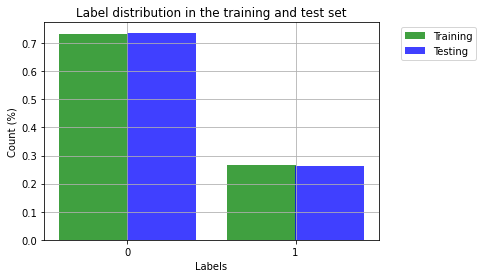

In [139]:
check_distribution(X2_train, X2_test, y2_train, y2_test)

### Naive Bayes (Gaussian)

In [69]:
set2_naiveg = tune_naiveg ('Round 2: Naive Bayes Gaussian', X2_train, X2_test, y2_train, y2_test)
set2_naiveg

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: Naive Bayes Gaussian,0.016,0.618,0.832,1251,463,131,480
1,Round 2: Naive Bayes Gaussian,0.012,0.618,0.832,1251,463,131,480
2,Round 2: Naive Bayes Gaussian,0.012,0.618,0.832,1251,463,131,480
3,Round 2: Naive Bayes Gaussian,0.012,0.618,0.832,1251,463,131,480
4,Round 2: Naive Bayes Gaussian,0.016,0.618,0.832,1251,463,131,480
5,Round 2: Naive Bayes Gaussian,0.017,0.618,0.832,1251,463,131,480
6,Round 2: Naive Bayes Gaussian,0.014,0.618,0.832,1251,463,131,480
7,Round 2: Naive Bayes Gaussian,0.013,0.619,0.833,1251,463,130,481
8,Round 2: Naive Bayes Gaussian,0.014,0.623,0.835,1249,465,124,487


### Naive Bayes (Bernoulli)

In [70]:
set2_naiveb = tune_bern('Round 2: Naive Bayes Bernoulli', X2_train, X2_test, y2_train, y2_test)
set2_naiveb

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: Naive Bayes Bernoulli,0.022,0.622,0.84,1337,377,165,446
1,Round 2: Naive Bayes Bernoulli,0.013,0.622,0.84,1337,377,165,446
2,Round 2: Naive Bayes Bernoulli,0.013,0.622,0.84,1337,377,165,446
3,Round 2: Naive Bayes Bernoulli,0.013,0.622,0.84,1337,377,165,446
4,Round 2: Naive Bayes Bernoulli,0.013,0.622,0.84,1337,377,165,446
5,Round 2: Naive Bayes Bernoulli,0.013,0.622,0.84,1337,377,165,446
6,Round 2: Naive Bayes Bernoulli,0.014,0.622,0.84,1337,377,165,446
7,Round 2: Naive Bayes Bernoulli,0.013,0.622,0.84,1337,377,165,446
8,Round 2: Naive Bayes Bernoulli,0.013,0.622,0.84,1337,377,165,446


### Decision trees

In [71]:
set2_tree = tune_tree('Round 2: Decison tree', X2_train, X2_test, y2_train, y2_test )
set2_tree

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: Decison tree,0.018,0.483,0.822,1605,109,382,229
1,Round 2: Decison tree,0.014,0.511,0.825,1568,146,351,260
2,Round 2: Decison tree,0.019,0.538,0.830,1559,155,329,282
3,Round 2: Decison tree,0.017,0.535,0.821,1569,145,335,276
4,Round 2: Decison tree,0.016,0.523,0.801,1563,151,341,270
5,Round 2: Decison tree,0.016,0.514,0.780,1538,176,339,272
6,Round 2: Decison tree,0.017,0.513,0.751,1494,220,324,287
7,Round 2: Decison tree,0.017,0.496,0.734,1448,266,322,289
8,Round 2: Decison tree,0.018,0.491,0.714,1410,304,313,298


### Random forest

In [72]:
set2_rf = tune_forest('Round 2: Random forest', X2_train, X2_test, y2_train, y2_test )
set2_rf

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: Random forest,0.071,0.518,0.770,1480,234,316,295
1,Round 2: Random forest,0.149,0.529,0.784,1460,254,300,311
2,Round 2: Random forest,0.289,0.530,0.788,1469,245,302,309
3,Round 2: Random forest,0.421,0.531,0.788,1472,242,303,308
4,Round 2: Random forest,0.529,0.526,0.789,1474,240,307,304
5,Round 2: Random forest,0.672,0.530,0.789,1471,243,303,308
6,Round 2: Random forest,0.823,0.536,0.789,1469,245,298,313
7,Round 2: Random forest,0.940,0.535,0.790,1473,241,300,311
8,Round 2: Random forest,1.068,0.531,0.789,1475,239,304,307


### Logistic regression

In [73]:
set2_log = tune_log('Round 2: Logistic regression', X2_train, X2_test, y2_train, y2_test )
set2_log

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: Logistic regression,0.044,0.584,0.845,1557,157,294,317
1,Round 2: Logistic regression,0.069,0.584,0.845,1559,155,295,316
2,Round 2: Logistic regression,0.084,0.585,0.845,1559,155,294,317
3,Round 2: Logistic regression,0.096,0.585,0.845,1559,155,294,317
4,Round 2: Logistic regression,0.111,0.585,0.845,1559,155,294,317
5,Round 2: Logistic regression,0.133,0.585,0.845,1559,155,294,317
6,Round 2: Logistic regression,0.110,0.585,0.845,1559,155,294,317
7,Round 2: Logistic regression,0.104,0.585,0.845,1559,155,294,317
8,Round 2: Logistic regression,0.113,0.585,0.845,1559,155,294,317


### K nearest neighbors

In [74]:
set2_knn = tune_knn('Round 2: K-nearest neighbors', X2_train, X2_test, y2_train, y2_test )
set2_knn

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: K-nearest neighbors,1.159,0.378,0.709,1562,152,433,178
1,Round 2: K-nearest neighbors,1.262,0.448,0.766,1538,176,384,227
2,Round 2: K-nearest neighbors,1.280,0.493,0.789,1531,183,351,260
3,Round 2: K-nearest neighbors,1.334,0.514,0.799,1544,170,341,270
4,Round 2: K-nearest neighbors,1.356,0.530,0.809,1520,194,321,290
5,Round 2: K-nearest neighbors,1.391,0.527,0.810,1511,203,320,291
6,Round 2: K-nearest neighbors,1.452,0.532,0.813,1509,205,315,296
7,Round 2: K-nearest neighbors,1.445,0.536,0.814,1513,201,314,297
8,Round 2: K-nearest neighbors,1.476,0.547,0.819,1517,197,307,304


### Support vector machines

In [75]:
set2_svc = tune_svc('Round 2: Support vector', X2_train, X2_test, y2_train, y2_test )
set2_svc

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: Support vector,0.084,0.605,0.833,1516,198,260,351
1,Round 2: Support vector,0.334,0.573,0.843,1563,151,305,306
2,Round 2: Support vector,0.567,0.573,0.843,1563,151,305,306
3,Round 2: Support vector,0.553,0.573,0.843,1563,151,305,306
4,Round 2: Support vector,0.567,0.573,0.843,1563,151,305,306
5,Round 2: Support vector,0.555,0.573,0.843,1563,151,305,306
6,Round 2: Support vector,0.562,0.573,0.843,1563,151,305,306
7,Round 2: Support vector,0.555,0.573,0.843,1563,151,305,306
8,Round 2: Support vector,0.558,0.573,0.843,1563,151,305,306


### MLP

In [76]:
set2_mlp = tune_mlp('Round 2: Multilayer perceptron', X2_train, X2_test, y2_train, y2_test )
set2_mlp

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iteratio

,Name,Time,F1,AucRoc,TP,FP,FN,TN
0,Round 2: Multilayer perceptron,0.874,0.584,0.841,1537,177,286,325
1,Round 2: Multilayer perceptron,1.785,0.579,0.833,1530,184,287,324
2,Round 2: Multilayer perceptron,2.020,0.562,0.830,1519,195,296,315
3,Round 2: Multilayer perceptron,2.400,0.582,0.829,1503,211,274,337
4,Round 2: Multilayer perceptron,2.698,0.559,0.825,1519,195,298,313
5,Round 2: Multilayer perceptron,3.022,0.562,0.823,1512,202,293,318
6,Round 2: Multilayer perceptron,3.403,0.546,0.821,1531,183,313,298
7,Round 2: Multilayer perceptron,4.251,0.559,0.816,1507,207,294,317
8,Round 2: Multilayer perceptron,5.029,0.546,0.812,1504,210,303,308


### Best of each model for round2

In [112]:
round2_frames = [set2_naiveg.iloc[8,:], set2_naiveb.iloc[6,:], set2_tree.iloc[2,:], 
                 set2_rf.iloc[6,:], set2_rf.iloc[7, :], set2_log.iloc[0,:], 
                 set2_knn.iloc[8,:], set2_svc.iloc[0,:], set2_mlp.iloc[2,:]]

round2_best = pd.concat(round2_frames, axis=1)
round2_best.columns = round2_best.iloc[0]
round2_best = round2_best.transpose()
round2_best = round2_best.drop(columns=['Name'])

round2_best = round2_best.sort_values('AucRoc', ascending=False)
round2_best.sort_values(by='Time')

,Time,F1,AucRoc,TP,FP,FN,TN
Name,,,,,,,
Round 2: Naive Bayes Bernoulli,0.014,0.622,0.84,1337,377,165,446
Round 2: Naive Bayes Gaussian,0.014,0.623,0.835,1249,465,124,487
Round 2: Decison tree,0.019,0.538,0.83,1559,155,329,282
Round 2: Logistic regression,0.044,0.584,0.845,1557,157,294,317
Round 2: Support vector,0.084,0.605,0.833,1516,198,260,351
Round 2: Random forest,0.823,0.536,0.789,1469,245,298,313
Round 2: Random forest,0.94,0.535,0.79,1473,241,300,311
Round 2: K-nearest neighbors,1.476,0.547,0.819,1517,197,307,304
Round 2: Multilayer perceptron,2.02,0.562,0.83,1519,195,296,315


In [78]:
avg_round2 = round2_best[['Time', 'F1', 'AucRoc', 'TN']]

avg_round2_agg = round(avg_round2.aggregate(['mean', 'min', 'max']), 2)
avg_round2_agg


,Time,F1,AucRoc,TN
mean,0.60,0.57,0.82,347.33
min,0.01,0.54,0.79,282.00
max,2.02,0.62,0.84,487.00


### Conclusions for round 2

* Best area under the curve: logistic regression
* Best F1 score: Naive Bayes Gaussian
* Best time: Naive Bayes Gaussian
* Best overall: Naive Bayes Gaussian, which is first in third in area under the curve, and first with F1 score and time.




## Compare results

In [79]:
top1 = round1_best.iloc[0:4,:]
top2 = round2_best.iloc[0:4,:]
frames = [top1, top2]

compare = pd.concat(frames)
compare

,Time,F1,AucRoc,TP,FP,FN,TN
Name,,,,,,,
Round 1: Logistic regression,0.11,0.61,0.843,1530,184,262,349
Round 1: Support vector,0.248,0.584,0.84,1544,170,289,322
Round 1: Multilayer perceptron,0.704,0.589,0.829,1546,168,286,325
Round 1: Naive Bayes Gaussian,0.01,0.617,0.828,1321,393,163,448
Round 2: Logistic regression,0.044,0.584,0.845,1557,157,294,317
Round 2: Naive Bayes Bernoulli,0.014,0.622,0.84,1337,377,165,446
Round 2: Naive Bayes Gaussian,0.014,0.623,0.835,1249,465,124,487
Round 2: Support vector,0.084,0.605,0.833,1516,198,260,351


### Largest area under the curve

In [80]:
compare.sort_values(by='AucRoc', ascending=False)

,Time,F1,AucRoc,TP,FP,FN,TN
Name,,,,,,,
Round 2: Logistic regression,0.044,0.584,0.845,1557,157,294,317
Round 1: Logistic regression,0.11,0.61,0.843,1530,184,262,349
Round 1: Support vector,0.248,0.584,0.84,1544,170,289,322
Round 2: Naive Bayes Bernoulli,0.014,0.622,0.84,1337,377,165,446
Round 2: Naive Bayes Gaussian,0.014,0.623,0.835,1249,465,124,487
Round 2: Support vector,0.084,0.605,0.833,1516,198,260,351
Round 1: Multilayer perceptron,0.704,0.589,0.829,1546,168,286,325
Round 1: Naive Bayes Gaussian,0.01,0.617,0.828,1321,393,163,448


### Highest F1 score


In [81]:
compare.sort_values(by='F1', ascending=False)

,Time,F1,AucRoc,TP,FP,FN,TN
Name,,,,,,,
Round 2: Naive Bayes Gaussian,0.014,0.623,0.835,1249,465,124,487
Round 2: Naive Bayes Bernoulli,0.014,0.622,0.84,1337,377,165,446
Round 1: Naive Bayes Gaussian,0.01,0.617,0.828,1321,393,163,448
Round 1: Logistic regression,0.11,0.61,0.843,1530,184,262,349
Round 2: Support vector,0.084,0.605,0.833,1516,198,260,351
Round 1: Multilayer perceptron,0.704,0.589,0.829,1546,168,286,325
Round 1: Support vector,0.248,0.584,0.84,1544,170,289,322
Round 2: Logistic regression,0.044,0.584,0.845,1557,157,294,317


### Fastest

In [82]:
compare.sort_values(by='Time', ascending=True)

,Time,F1,AucRoc,TP,FP,FN,TN
Name,,,,,,,
Round 1: Naive Bayes Gaussian,0.01,0.617,0.828,1321,393,163,448
Round 2: Naive Bayes Bernoulli,0.014,0.622,0.84,1337,377,165,446
Round 2: Naive Bayes Gaussian,0.014,0.623,0.835,1249,465,124,487
Round 2: Logistic regression,0.044,0.584,0.845,1557,157,294,317
Round 2: Support vector,0.084,0.605,0.833,1516,198,260,351
Round 1: Logistic regression,0.11,0.61,0.843,1530,184,262,349
Round 1: Support vector,0.248,0.584,0.84,1544,170,289,322
Round 1: Multilayer perceptron,0.704,0.589,0.829,1546,168,286,325


### Round 1 vs round 2

In [100]:
frames4 = [set1_naiveg, set1_naiveb, set1_tree, set1_rf, set1_log, set1_knn, set1_svc, set1_mlp,
           set2_naiveg, set2_naiveb, set2_tree, set2_rf, set2_log, set2_knn, set2_svc, set2_mlp]
          
all_results = pd.concat(frames4)
all_results['Round'] = all_results['Name'].str[0:7]
all_results.head()

,Name,Time,F1,AucRoc,TP,FP,FN,TN,Round
0,Round 1: Naive Bayes Gaussian,0.016,0.619,0.828,1325,389,163,448,Round 1
1,Round 1: Naive Bayes Gaussian,0.010,0.617,0.828,1321,393,163,448,Round 1
2,Round 1: Naive Bayes Gaussian,0.010,0.606,0.813,1307,407,168,443,Round 1
3,Round 1: Naive Bayes Gaussian,0.010,0.571,0.779,1386,328,236,375,Round 1
4,Round 1: Naive Bayes Gaussian,0.009,0.545,0.768,1427,287,275,336,Round 1


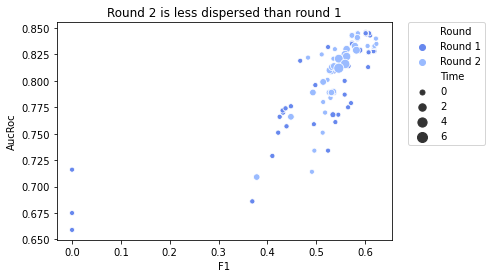

In [141]:
ax = sns.scatterplot(x="F1", y="AucRoc",
                     size="Time", hue="Round", 
                     sizes=(25, 100), 
                     data=all_results,
                     cmap='coolwarm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Round 2 is less dispersed than round 1')
plt.show()

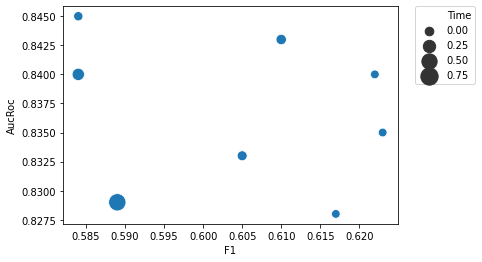

In [97]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="F1", y="AucRoc",
                     size="Time", #hue="Time", 
                     sizes=(75, 300), #palette=cmap
                     data=compare)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [83]:
print(avg_round1_agg)

      Time    F1  AucRoc      TN
mean  0.26  0.57  0.82    334.67
min   0.01  0.45  0.78    207.00
max   1.08  0.62  0.84    448.00


In [84]:
print(avg_round2_agg)

      Time    F1  AucRoc      TN
mean  0.60  0.57  0.82    347.33
min   0.01  0.54  0.79    282.00
max   2.02  0.62  0.84    487.00


In [85]:
frames3 = [avg_round1_agg, avg_round2_agg]
compare_rounds = pd.concat(frames3, axis= 1)
compare_rounds.columns = ['1_Time', '1_F1', '1_AucRoc', '1_TN', '2_Time', '2_F1', '2_AucRoc', '2_TN']
compare_rounds

,1_Time,1_F1,1_AucRoc,1_TN,2_Time,2_F1,2_AucRoc,2_TN
mean,0.26,0.57,0.82,334.67,0.60,0.57,0.82,347.33
min,0.01,0.45,0.78,207.00,0.01,0.54,0.79,282.00
max,1.08,0.62,0.84,448.00,2.02,0.62,0.84,487.00


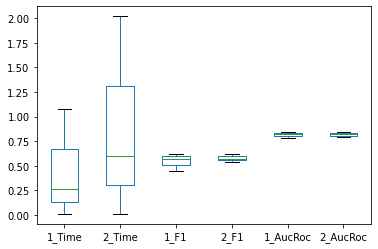

In [108]:

ax = compare_rounds[['1_Time', '2_Time',	'1_F1',	'2_F1',	'1_AucRoc', '2_AucRoc']].plot(kind='box')
plt.show()

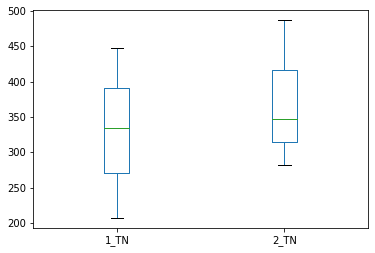

In [87]:
bx = compare_rounds[['1_TN', '2_TN']].plot(kind='box')
plt.show()

In [88]:
# what does perfect prediction look like? 
confusion_matrix(y1_test, y1_test)

array([[1714,    0],
       [   0,  611]])

In [89]:
confusion_matrix(y2_test, y2_test)

array([[1714,    0],
       [   0,  611]])

In [111]:
# what percentage of true negatives are classified correctly?
tn_pct = compare_rounds.loc[:, ['1_TN', '2_TN']]
tn_pct.loc[:,'1_TNPct'] = round(tn_pct.loc[:,'1_TN']/611,2)
tn_pct.loc[:,'2_TNPct'] = round(tn_pct.loc[:,'2_TN']/611,2)
tn_pct

,1_TN,2_TN,1_TNPct,2_TNPct
mean,334.67,347.33,0.55,0.57
min,207.00,282.00,0.34,0.46
max,448.00,487.00,0.73,0.80


# Conclusions

### Which machine learning model works best for binary classification?
This depends on how you define "best", but assuming that you care about F1 score and area under the curve, Naive Bayes (Gaussian), Logistic regression, and MLP are all good. 


### Does one-hot encoding impact the results?
Yes, but not as much as I expected. And the increased number of columns slowed several of the models down; if speed were an issue it might not be worth it to encode the variables. 


### Which metrics are useful in evaluating an imbalanced binary classification dataset?
F1 scored ended up being more useful than area under the curve. I also found it valuable to look at true negative classifications explictly (they are part of F1 score), and would continue to use this for imbalanced datasets. 

# Next steps

New questions:

* If the dataset is balanced, how does that impact the results? Does up-sampling, down-sampling, or a combination work best to even out the cases? 
* I'd like to explore Navie Bayes, MLP, and Logistic regression more. Next time, I can use cross validation and GridSearch to try more tuning parameters. 